In [1]:
import os
import mpbn
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.proportion import proportions_ztest
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

work_dir = '/home/spankaew/Git/BooleanBenchmark/'
project = 'Invasion'
model_dir = work_dir + 'models/' + project + '/'
#output_dir = work_dir + 'models/tmp/' + project + '/'

In [2]:
def clause_string(logic):
    logic_rules = []
    if logic == False:
        logic_rules = ['0']
    elif logic == True:
        logic_rules = ['1']
    for i in range(len(logic)):
        logic_clause = logic[i].copy()
        formatted_strings = [f"{t[0]}" if t[1] else f"!{t[0]}" for t in logic_clause]
        single_line_string = ' & '.join(formatted_strings)
        logic_rules.append(single_line_string)
    return(logic_rules)

def dataframe_model_dnf(model_dnf):
    node_names = list(model_dnf.keys())
    logic_mtx = pd.DataFrame()
    for i in node_names:
        logic_mtx = pd.concat([logic_mtx,pd.DataFrame(clause_string(model_dnf[i]))], 
                        axis = 1, ignore_index = False,)
    logic_mtx = logic_mtx.applymap(lambda x: f"({x})" if isinstance(x, str) else x)    
    logic_mtx=logic_mtx.transpose()
    logic_mtx = logic_mtx.fillna('')
    logic_mtx.index = node_names
    logic_full = logic_mtx.agg(' | '.join, axis=1).str.strip(' | ')
    return(logic_full)

In [7]:
model_files = os.listdir(model_dir)
model_logic = pd.DataFrame()

for i in tqdm(model_files):
    # Load file
    model = mpbn.load(model_dir + i)
    # Convert to dnf and dnf string
    model = model.as_dnf()
    model = dataframe_model_dnf(model)
    model.name = i.split('.')[0]
    # Concatenate to matrix
    model_logic = pd.concat([model_logic, model], axis = 1, ignore_index = False)

model_logic.to_csv(work_dir + 'tmp/Invasion_model_logic.csv')    

  0%|          | 0/1025 [00:00<?, ?it/s]

100%|██████████| 1025/1025 [03:59<00:00,  4.28it/s]


In [5]:
model_logic = pd.read_csv(work_dir + 'tmp/Invasion_model_logic.csv')

In [8]:
model_cluster = pd.read_csv(work_dir + 'tmp/Invasion_model_clusters.csv', index_col = 0)
model_cluster = model_cluster.sort_values('cluster')
model_cluster

,cluster
Invasion_558,0
Invasion_592,0
Invasion_591,0
Invasion_590,0
Invasion_589,0
...,...
Invasion_143,5
Invasion_138,5
Invasion_491,5
Invasion_312,5


In [9]:
var_logic_clust = pd.DataFrame()
for i in list(model_cluster.cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster.cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.cluster.unique())

In [10]:
model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index
var_logic_clust= var_logic_clust.loc[sort_index]

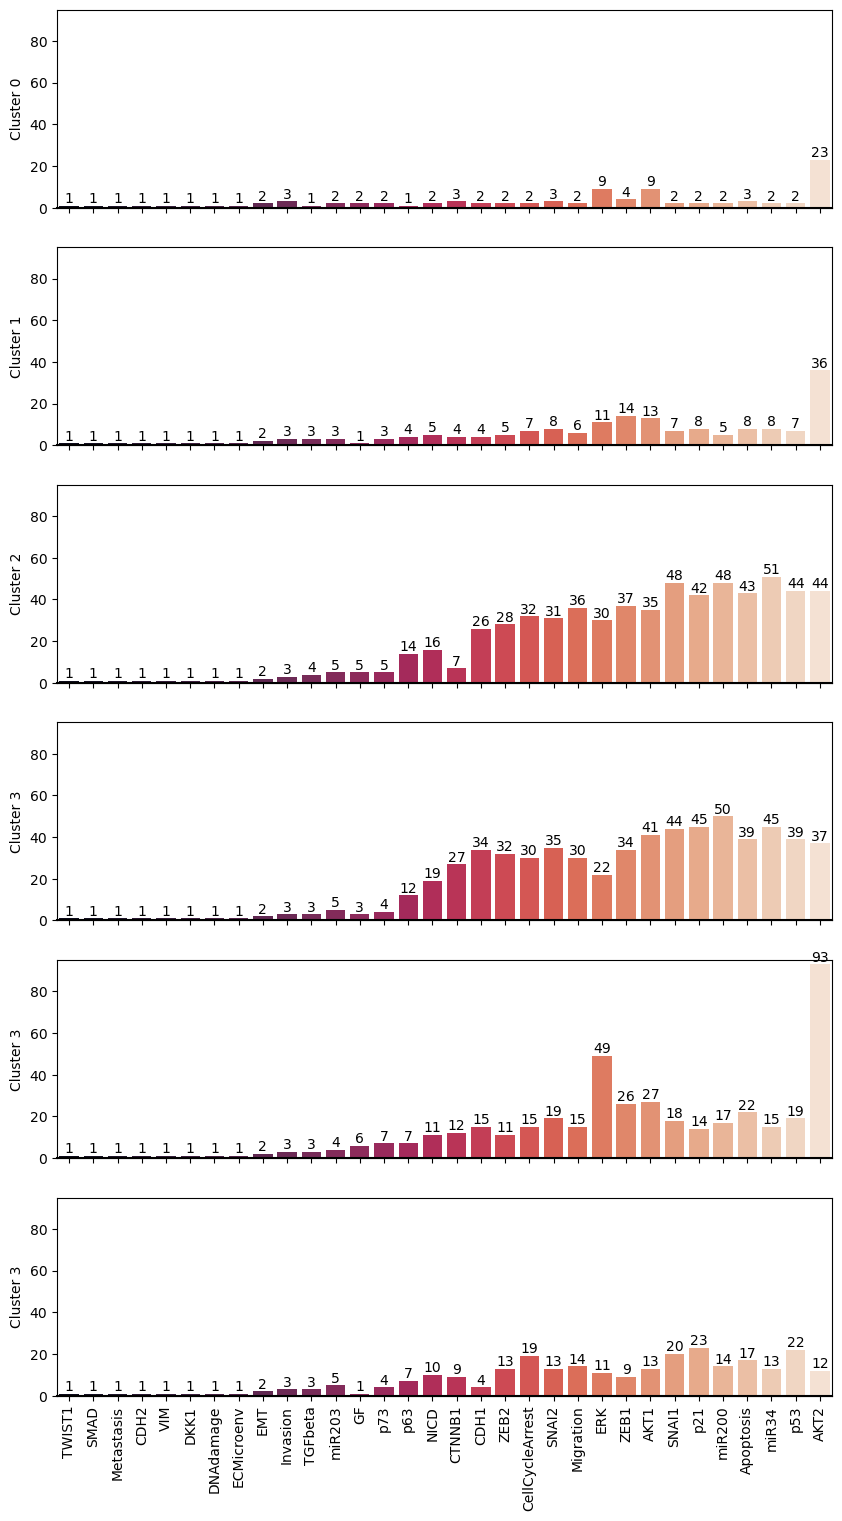

In [11]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 18), sharex=True)
plt.ylim(0,65)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[0], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Cluster 0")
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[1], palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Cluster 1")
ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[2], palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Cluster 2")
ax3.bar_label(ax3.containers[0], fontsize=10)
ax3.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[3], palette="rocket", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("Cluster 3")
ax4.bar_label(ax4.containers[0], fontsize=10)
ax4.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[4], palette="rocket", ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_ylabel("Cluster 3")
ax5.bar_label(ax5.containers[0], fontsize=10)
ax5.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[5], palette="rocket", ax=ax6)
ax6.axhline(0, color="k", clip_on=False)
ax6.set_ylabel("Cluster 3")
ax6.bar_label(ax6.containers[0], fontsize=10)
ax6.set_ylim(0,95)


plt.xticks(rotation = 90)
plt.show()

In [12]:
from collections import Counter
# Function to count strings in a row
def count_strings_in_row(row):
    return Counter(row)

def split_gene_clauses(model_logic_mtx, gene): 
    split_data = [item.split(" | ") for item in model_logic_mtx.loc[gene]]
    df = pd.DataFrame(split_data, index = model_logic_mtx.loc[gene].index)
    return(df)

def logic_clause_frequency(model_logic_mtx):
    logic_clause = pd.DataFrame()
    for i in model_logic_mtx.index:
        df = split_gene_clauses(model_logic_mtx, i)
        df = df.fillna(0)

        from collections import Counter
        # Function to count strings in a row
        def count_strings_in_row(row):
            return Counter(row)

        # Apply the function to each row and convert the result to a DataFrame
        row_counts = df.apply(lambda row: pd.Series(count_strings_in_row(row)), 
                                    axis=1).fillna(0)
        clauses = row_counts.sum()/len(df)
        logic_clause = pd.concat([logic_clause,clauses], ignore_index = True, axis = 1)
    logic_clause= logic_clause.fillna(0)
    logic_clause.columns = model_logic_mtx.index
    return(logic_clause)

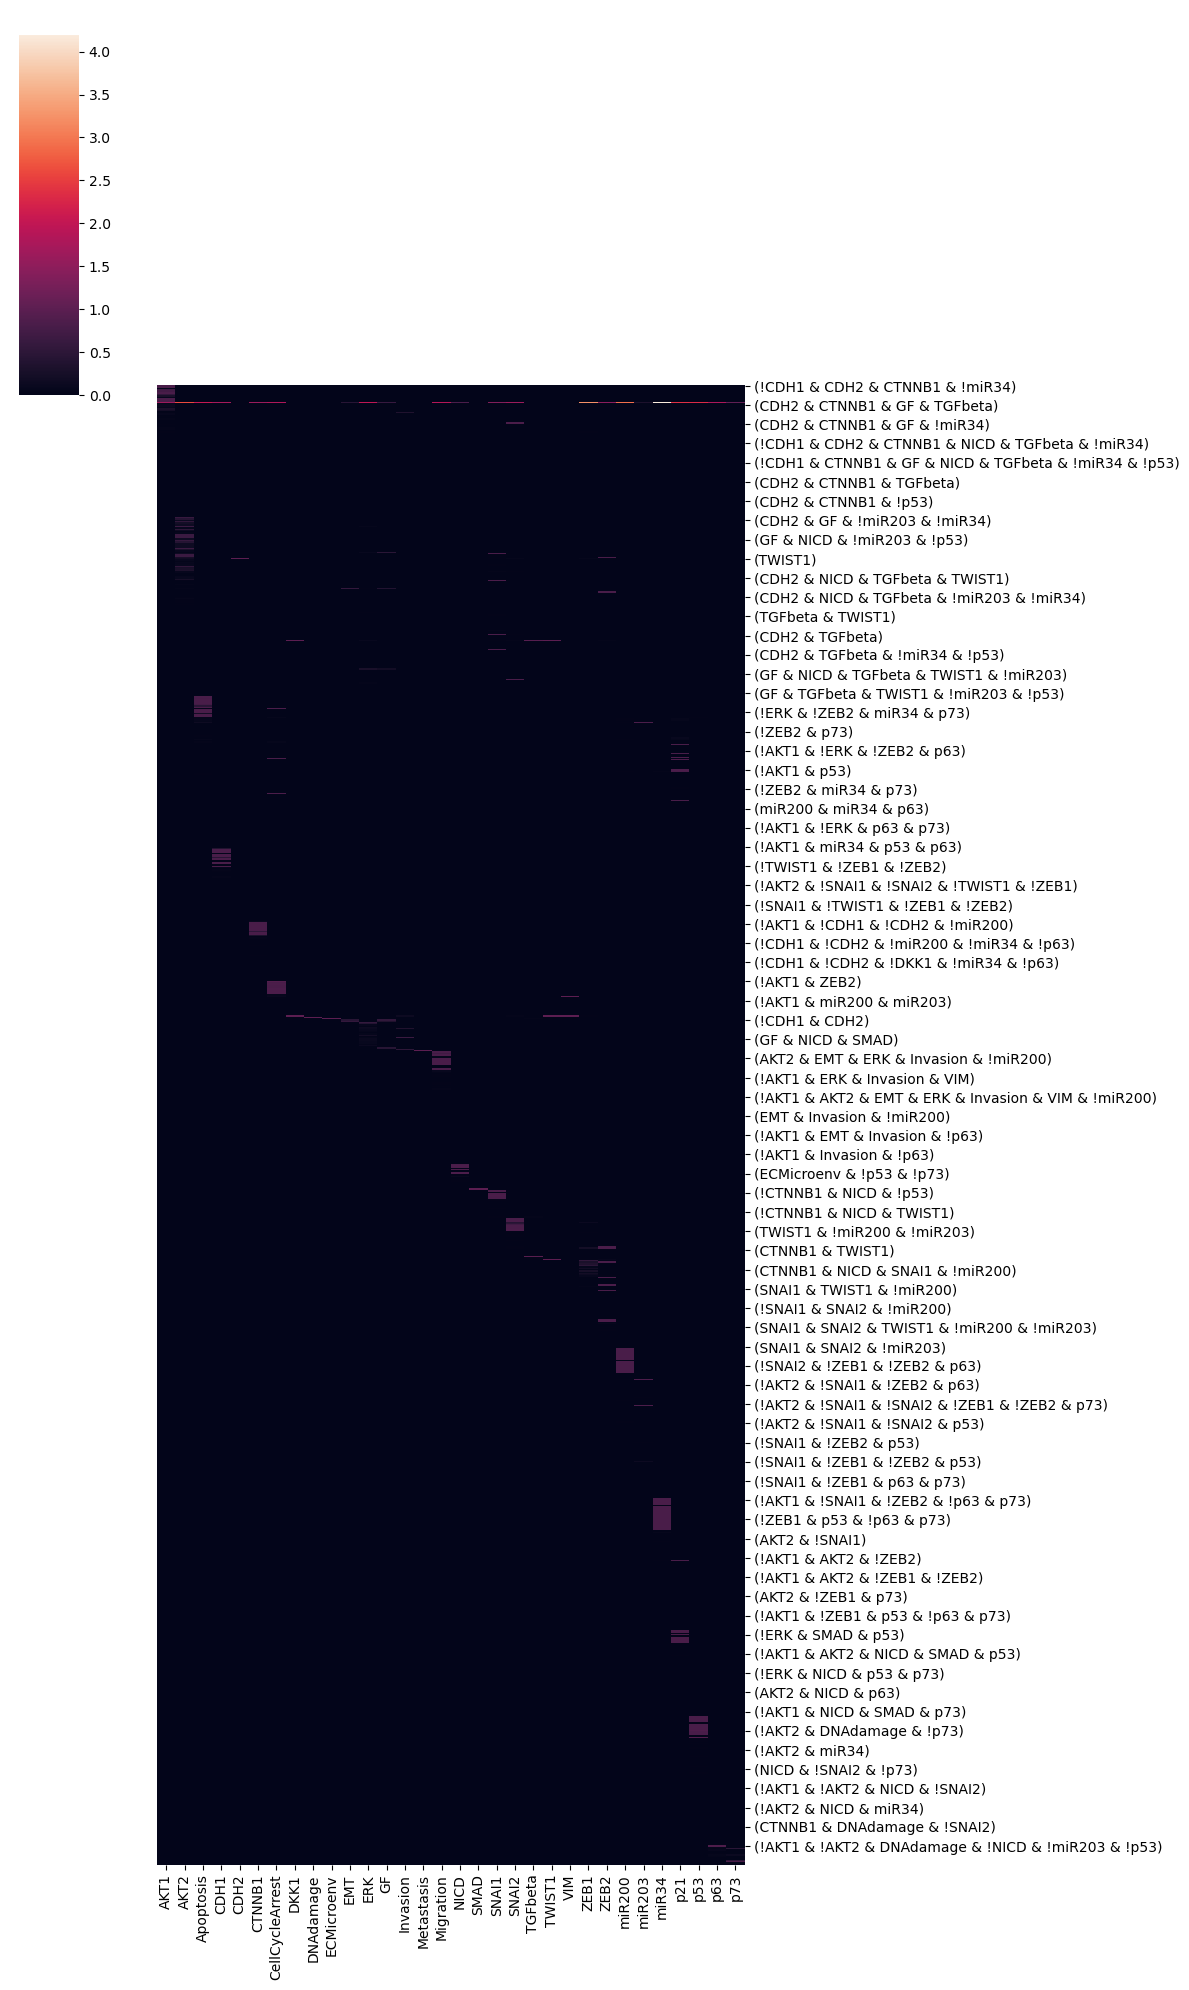

In [13]:
logic_cluase = logic_clause_frequency(model_logic)
sns.clustermap(logic_cluase, col_cluster = False, row_cluster = False, figsize = (12,20))
plt.show()

In [14]:
model_name = list(model_logic.columns)
logic_clause_flattend = pd.DataFrame()

for i in tqdm(model_name):
    clause = logic_clause_frequency(model_logic[[i]]).transpose()
    clause = clause.stack()
    clause.index = clause.index.map('_'.join)
    clause = clause.loc[~(clause == 0)]
    logic_clause_flattend= pd.concat([logic_clause_flattend,clause], ignore_index = False, axis = 1)

# Fill NA to 0
logic_clause_flattend = logic_clause_flattend.fillna(0)

# Add the column name
logic_clause_flattend.columns = model_name

  0%|          | 0/1025 [00:00<?, ?it/s]

100%|██████████| 1025/1025 [01:54<00:00,  8.96it/s]


/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


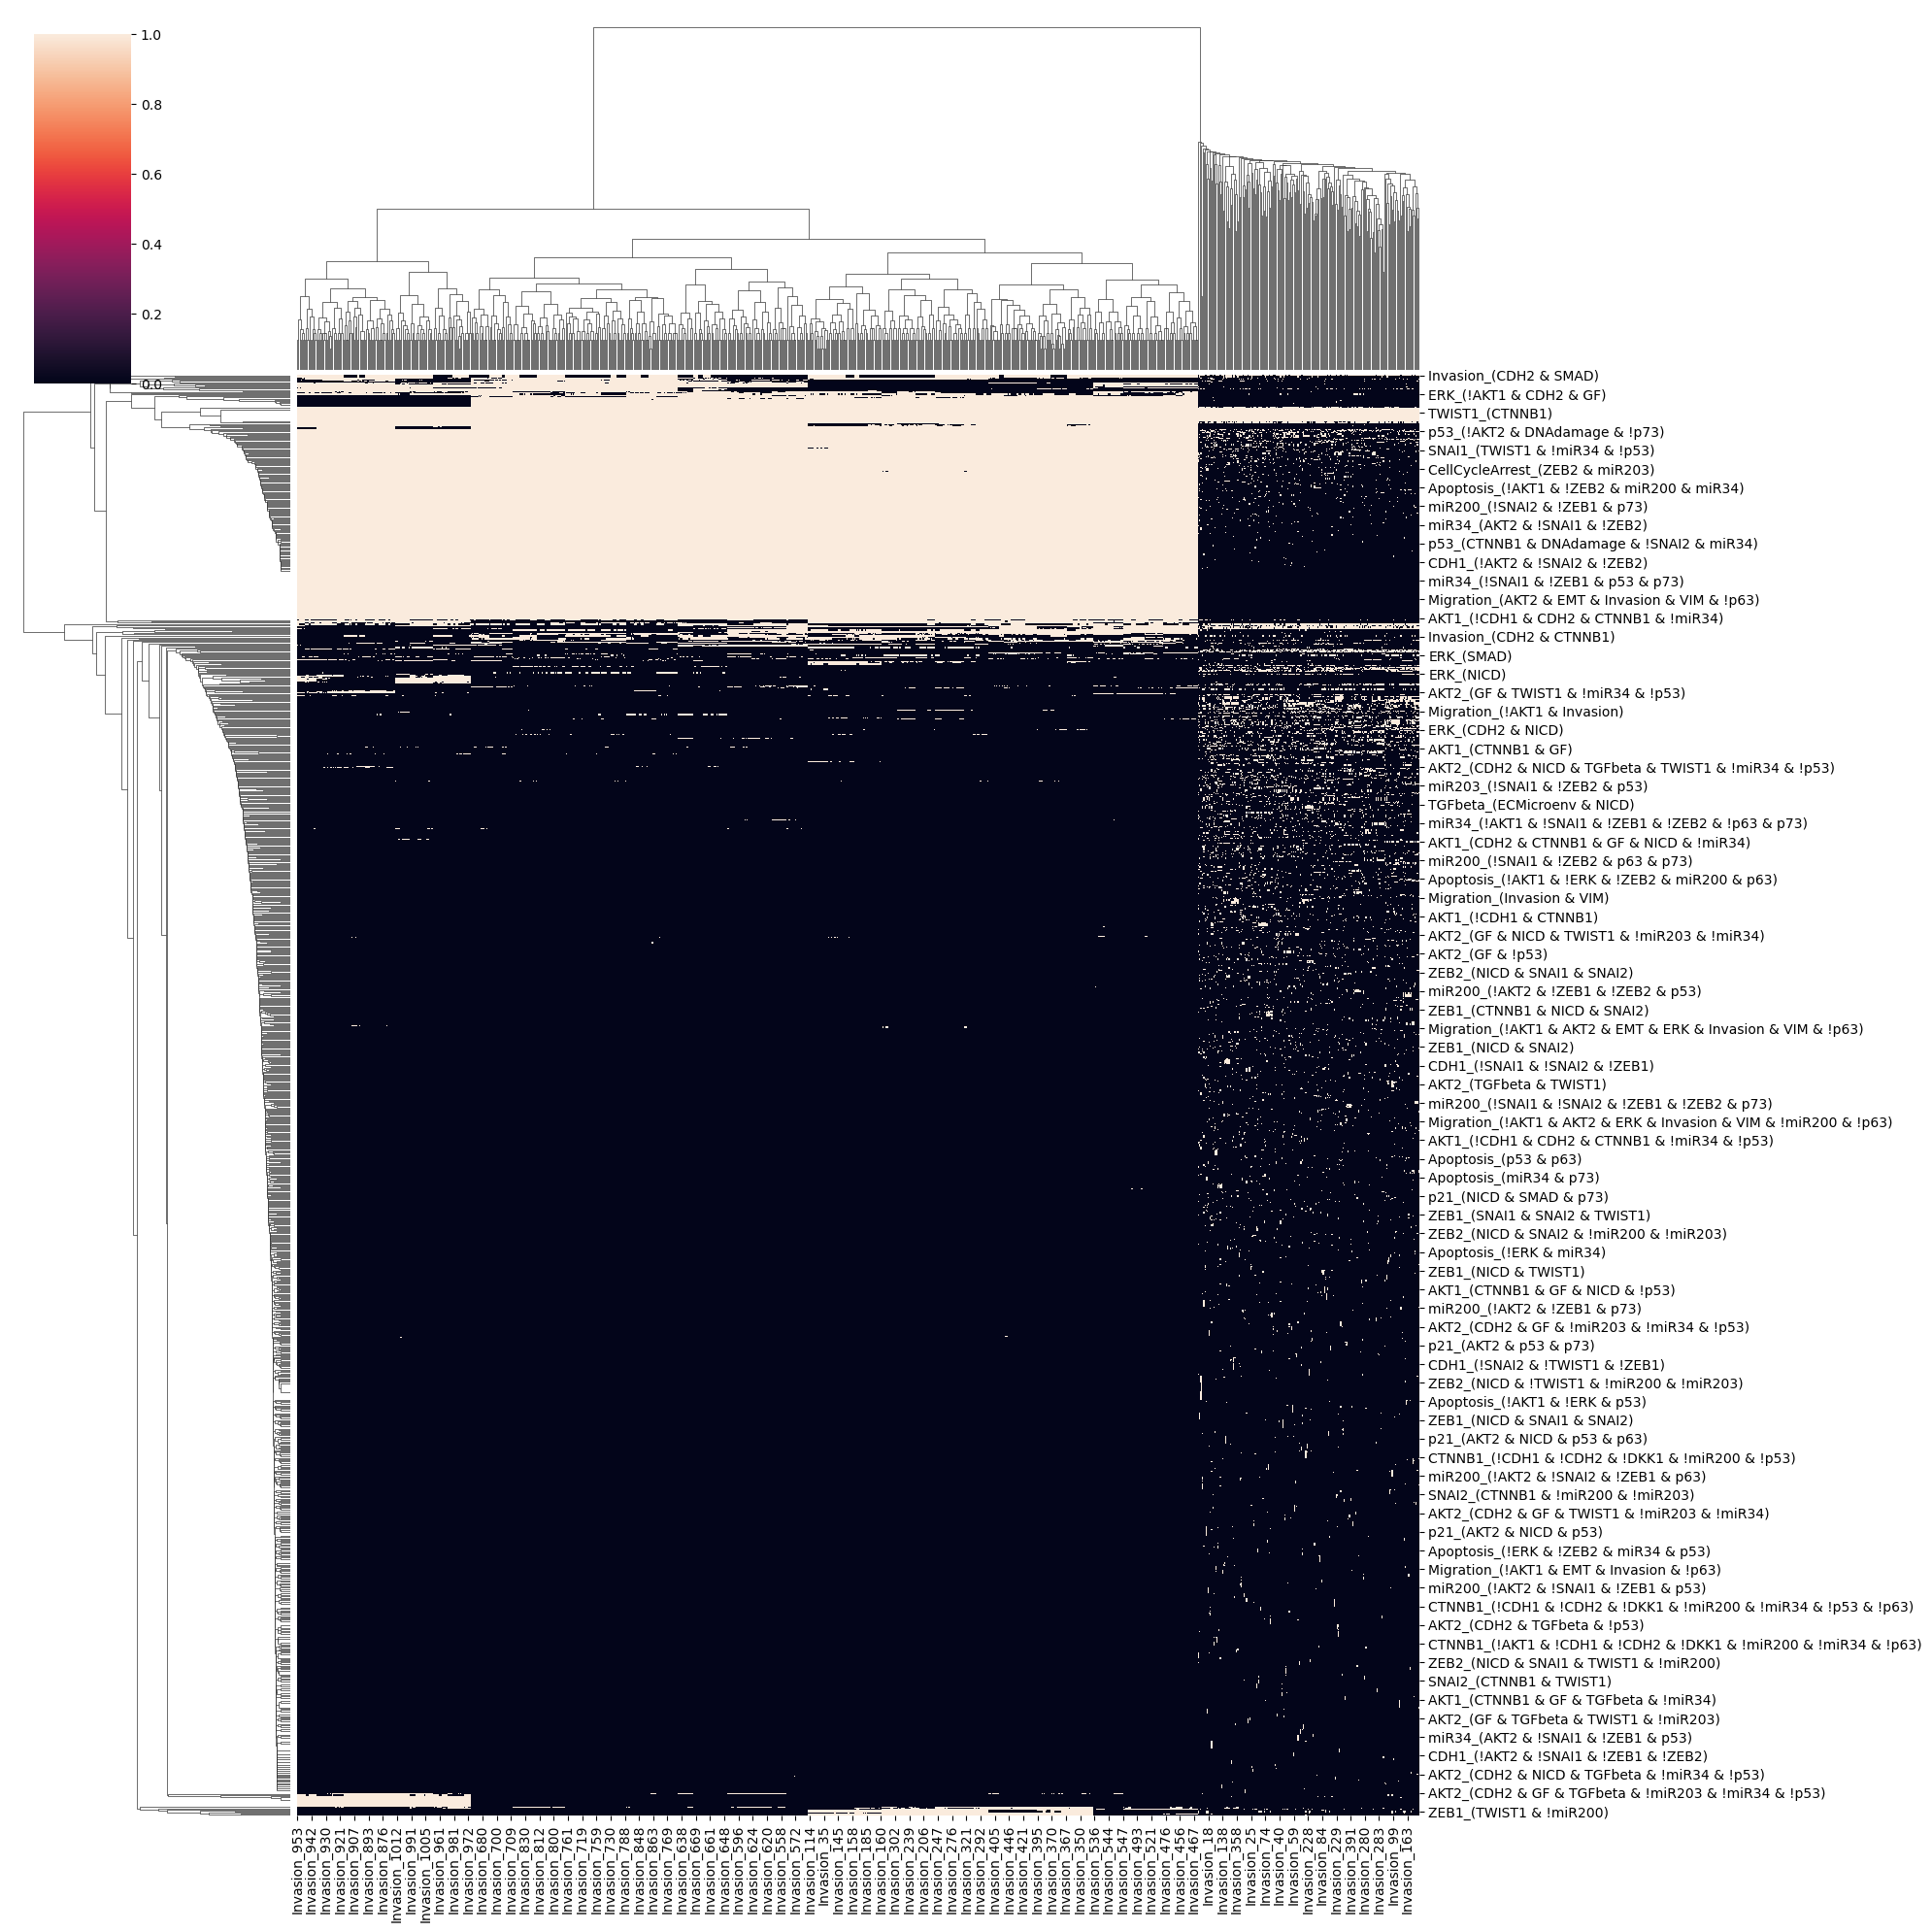

In [14]:
sns.clustermap(logic_clause_flattend, figsize = (20,20))

In [15]:
# Initialize PCA (let's reduce to 2 principal components for this example)
pca = PCA(n_components=10)

# Fit and transform the data
df_transposed = logic_clause_flattend.transpose()
pca_result = pca.fit_transform(df_transposed)

# Convert the result back to a DataFrame for easier interpretation
pca_df = pd.DataFrame(data=pca_result, index=df_transposed.index)

# number pca column
number_list = list(range(pca_result.shape[1]))
str_list = [str(i+1) for i in number_list]
pca_df.columns = ['pc' + s for s in str_list]

# Add cluster
pca_df['cluster'] = model_cluster.cluster.astype('str')

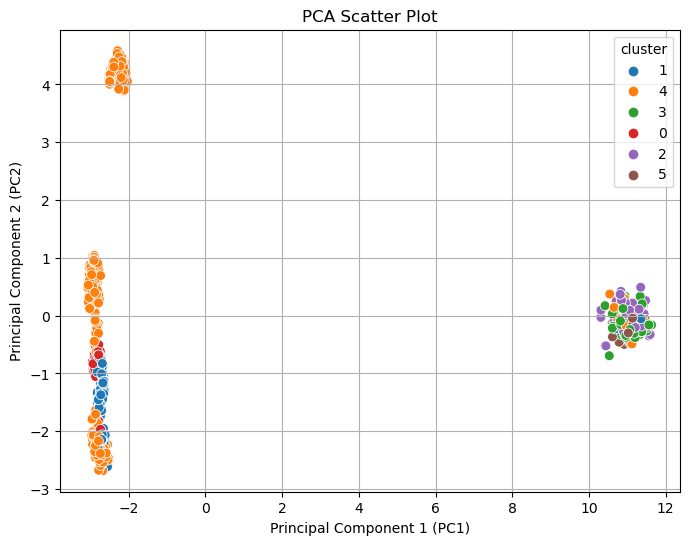

In [16]:
plt.figure(figsize=(8, 6))

# Scatter plot using Seaborn
sns.scatterplot(x='pc1', y='pc2', data=pca_df, s=50, hue = 'cluster')

# Add title and labels
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Display the plot
plt.grid(True)
plt.show()

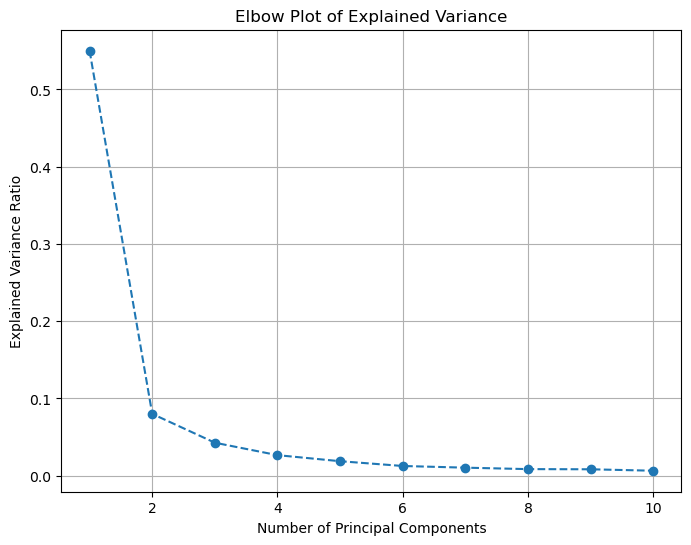

In [17]:
explained_variance_ratio = pca.explained_variance_ratio_

# Create an array with the number of components (1, 2, ..., n)
components = np.arange(1, len(explained_variance_ratio) + 1)

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')

# Add titles and labels
plt.title('Elbow Plot of Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')

# Add a grid
plt.grid(True)

# Display the plot
plt.show()

In [18]:
from sklearn.cluster import KMeans

# Assume k=2 (you can choose a different number based on the Elbow Method)
kmeans = KMeans(n_clusters=5, random_state=12345)

# Fit the k-means model and predict cluster labels
clusters = kmeans.fit_predict(pca_df)

# Add the cluster labels to the PCA DataFrame
pca_df['Kmean_Cluster'] = clusters

/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


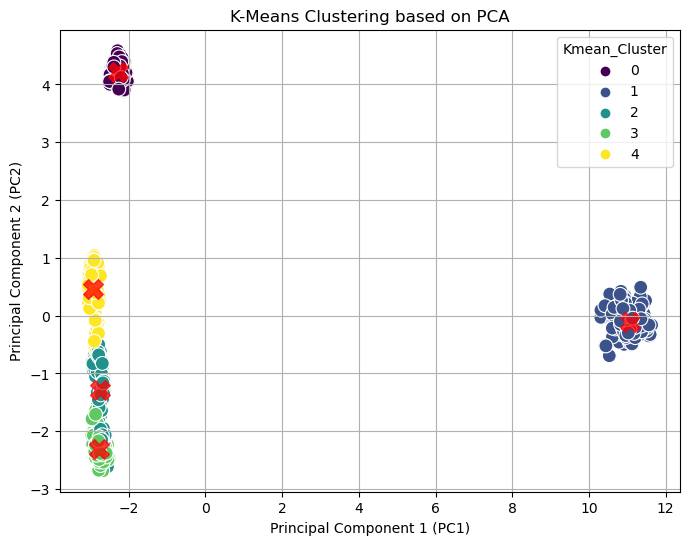

In [19]:
plt.figure(figsize=(8, 6))

# Scatter plot colored by cluster
sns.scatterplot(x='pc1', y='pc2', hue='Kmean_Cluster', data=pca_df, palette='viridis', s=100)

# Add cluster centers to the plot
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')

# Add title and labels
plt.title('K-Means Clustering based on PCA')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Display the plot
plt.grid(True)
plt.show()

In [33]:
def find_all_markerrules(logic_clause, cluster_group):
    cluster_group = pca_df.cluster
    cluster_group = cluster_group.astype('category')
    cluster_group.cat.categories

    logic_feature_df = logic_clause.transpose()
    logic = list(logic_feature_df.columns)
    oddsratio_all = pd.DataFrame()
    p_value_all = pd.DataFrame()

    for i in list(cluster_group.cat.categories):
        print('calculate statistic for cluster : ' + str(i))
        odds_ratio_group = []
        p_value_group = []
        for j in tqdm(logic):
            # Select logic feature
            group1 = list(logic_feature_df.loc[cluster_group[cluster_group == i].index,j])
            group2 = list(logic_feature_df.loc[cluster_group[cluster_group != i].index,j])

            # Create a contingency table
            contingency_table = [group1.count(1), group2.count(1)]
            nobs = [len(group1), len(group2)]

            # Perform Fisher's Exact Test
            oddsratio, p_value = proportions_ztest(contingency_table,nobs)

            # Attach value to list
            odds_ratio_group.append(oddsratio)
            p_value_group.append(p_value)

        # Concat the odd_ratio and p_val
        oddsratio_all = pd.concat([oddsratio_all, pd.Series(odds_ratio_group)], axis = 1)
        p_value_all = pd.concat([p_value_all, pd.Series(p_value_group)], axis = 1)

    # Adjust odds ratio matrix
    oddsratio_all = oddsratio_all.transpose()
    oddsratio_all.columns = logic
    oddsratio_all.index = list(cluster_group.cat.categories)

    # Adjust p value matrix
    p_value_all = p_value_all.transpose()
    p_value_all.columns = logic
    p_value_all.index = list(cluster_group.cat.categories)

    # Return dictionary of z-score and p-value
    results = dict({'z-score' : oddsratio_all, 
                    'p_value' : p_value_all})
    
    return(results)

In [34]:
zscore_mtx = find_all_markerrules(logic_clause_flattend, cluster_group)

calculate statistic for cluster : 0


  0%|          | 0/1313 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
100%|██████████| 1313/1313 [00:01<00:00, 769.59it/s]


calculate statistic for cluster : 1


  0%|          | 0/1313 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
100%|██████████| 1313/1313 [00:01<00:00, 770.30it/s]


calculate statistic for cluster : 2


  0%|          | 0/1313 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
100%|██████████| 1313/1313 [00:01<00:00, 812.38it/s]


calculate statistic for cluster : 3


  0%|          | 0/1313 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
100%|██████████| 1313/1313 [00:01<00:00, 792.36it/s]


calculate statistic for cluster : 4


  0%|          | 0/1313 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
100%|██████████| 1313/1313 [00:01<00:00, 758.02it/s]


calculate statistic for cluster : 5


  0%|          | 0/1313 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
100%|██████████| 1313/1313 [00:01<00:00, 805.03it/s]


In [52]:
def find_markerrules(logic_clause, 
                     cluster_group_1,
                     cluster_group_2):
    
    logic_feature_df = logic_clause.transpose()
    logic = list(logic_feature_df.columns)

    odds_ratio_group = []
    p_value_group = []

    for j in logic:
        # Select logic feature
        group1 = list(logic_feature_df.loc[cluster_group_1,j])
        group2 = list(logic_feature_df.loc[cluster_group_2,j])

        # Create a contingency table
        contingency_table = [group1.count(1), group2.count(1)]
        nobs = [len(group1), len(group2)]

        # Perform Fisher's Exact Test
        oddsratio, p_value = proportions_ztest(contingency_table,nobs)

        # Attach value to list
        odds_ratio_group.append(oddsratio)
        p_value_group.append(p_value)

    # Concat the odd_ratio and p_val
    zscore_mtx = pd.concat([pd.Series(odds_ratio_group),
                            pd.Series(p_value_group)],
                            axis = 1)
    zscore_mtx.index = logic
    zscore_mtx.columns = ['z_score','p-value']

    return(zscore_mtx)
    

In [53]:
test = find_markerrules(logic_clause_flattend,
                 cluster_group_1 = cluster_group.index[cluster_group=='0'],
                 cluster_group_2 = cluster_group.index[cluster_group=='1'])

/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


In [75]:
def volcano_plot(calculate_stat, zscore_threshold, pvalue_threshold=0.05):
    df = calculate_stat
    df['-log10(pvalue)'] = -np.log10(df['p-value'])

    # Set threshold values
    zscore_threshold = zscore_threshold  # Fold change threshold
    pvalue_threshold = pvalue_threshold  # p-value threshold
    significance_threshold = -np.log10(pvalue_threshold)

    # Create a scatter plot
    plt.figure(figsize=(10, 7))
    plt.scatter(df['z_score'], df['-log10(pvalue)'], color='grey', alpha=0.7)

    # Highlight points of interest
    significant_up = df[(df['z_score'] > zscore_threshold) & (df['-log10(pvalue)'] > significance_threshold)]
    significant_down = df[(df['z_score'] < -zscore_threshold) & (df['-log10(pvalue)'] > significance_threshold)]

    plt.scatter(significant_up['z_score'], significant_up['-log10(pvalue)'], color='red', label='Upregulated')
    plt.scatter(significant_down['z_score'], significant_down['-log10(pvalue)'], color='blue', label='Downregulated')

    # Add horizontal and vertical lines to mark thresholds
    plt.axhline(y=significance_threshold, color='black', linestyle='--')
    plt.axvline(x=zscore_threshold, color='black', linestyle='--')
    plt.axvline(x=-zscore_threshold, color='black', linestyle='--')

    # Annotate significant genes
    for i in significant_up.index:
        plt.annotate(i, (df['z_score'][i], df['-log10(pvalue)'][i]),
                    textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='black')

    for i in significant_down.index:
        plt.annotate(i, (df['z_score'][i], df['-log10(pvalue)'][i]),
                    textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='black')

    # Add labels and title
    plt.xlabel('z_score')
    plt.ylabel('-log10(p-value)')
    plt.title('Volcano Plot')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

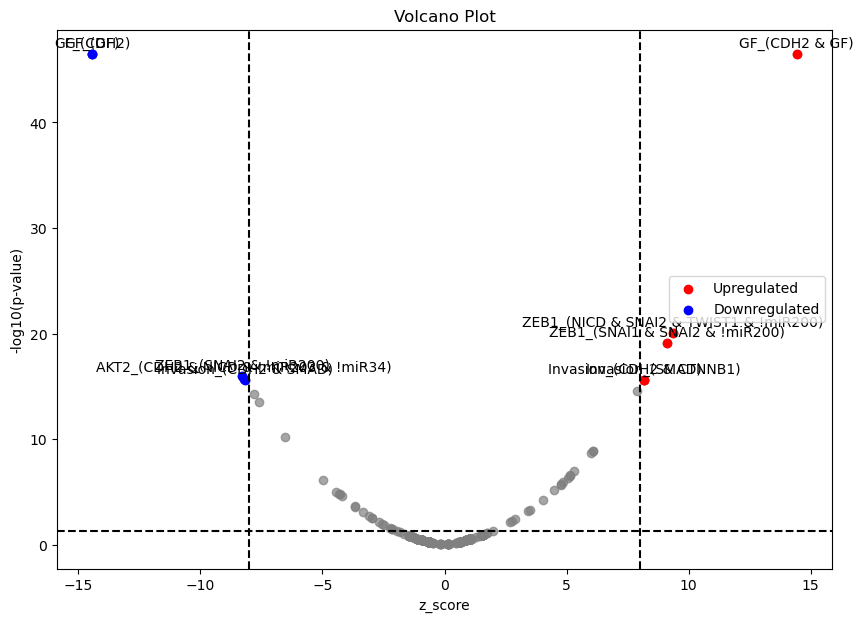

In [76]:
volcano_plot(test, zscore_threshold=8, pvalue_threshold=0.05)

/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


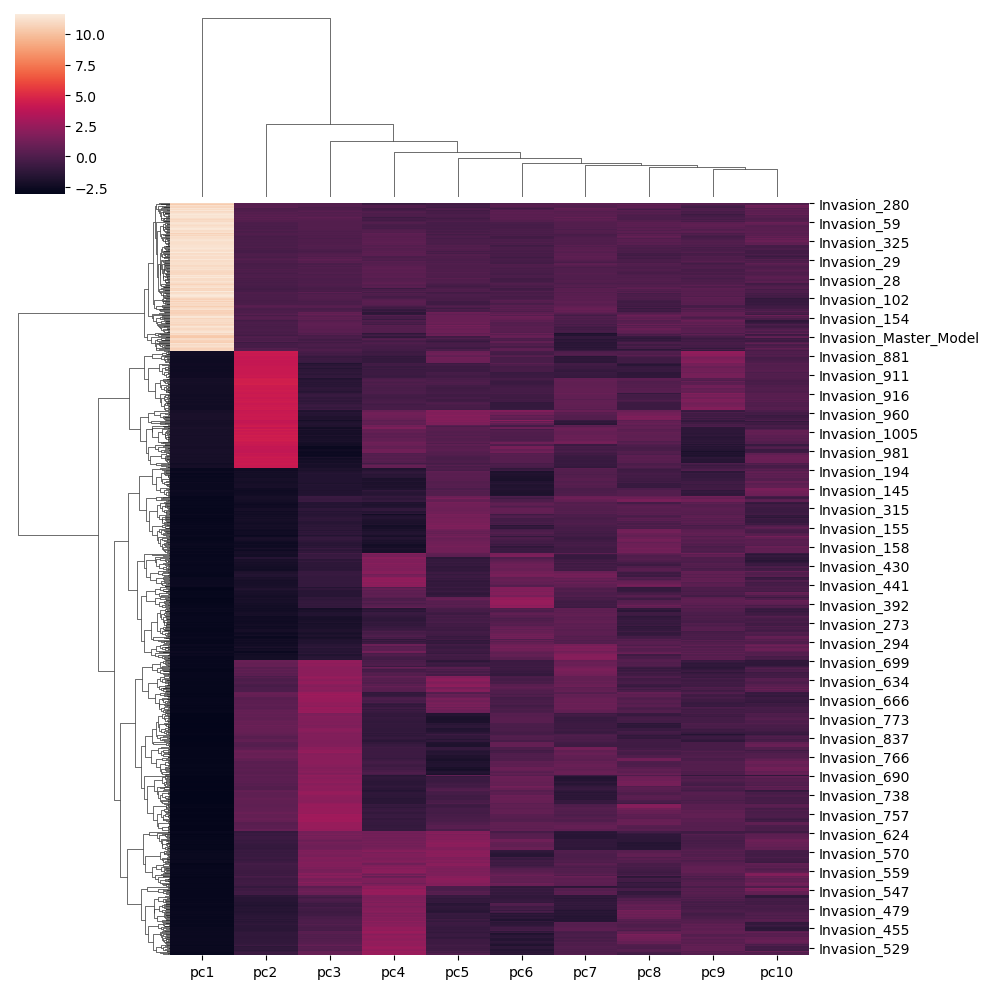

In [22]:
sns.clustermap(pca_df.drop(['cluster','Kmean_Cluster'], axis = 1))

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame
logic_clause = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 0]])
logic_clause = logic_clause[sort_index]
data = logic_clause.transpose()
df = pd.DataFrame(data)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on DataFrame
for level in range(len(df.index) - 1):
    for col in df.columns:
        parent = (level, col)
        child_level = level + 1
        for child_col in df.columns:
            child = (child_level, child_col)
            # Add edge with weight as the activity level of the child node
            G.add_edge(parent, child, weight=df.loc[df.index[child_level], child_col])

# Add node attributes for activity level
for level in range(len(df.index)):
    for col in df.columns:
        node = (level, col)
        G.nodes[node]['activity'] = df.loc[df.index[level], col]

# Identify nodes with activity level of 0
nodes_to_remove = [node for node in G.nodes if G.nodes[node]['activity'] == 0]

# Remove these nodes and their associated edges
G.remove_nodes_from(nodes_to_remove)

# Position nodes in a grid layout
pos = {}
for level in range(len(df.index)):
    for i, col in enumerate(df.columns):
        pos[(level, col)] = (i, -level)

# Draw the network
plt.figure(figsize=(14, 14))

# Draw the nodes with sizes proportional to activity levels
node_sizes = [G.nodes[node]['activity'] * 300 for node in G.nodes]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_sizes, font_weight='bold', node_shape='o')

# Draw the edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color='gray')

# Draw the edge labels with weights
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Set grid
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set title
plt.title('Hierarchical Network with Grid Layout')

plt.show()

KeyboardInterrupt: 

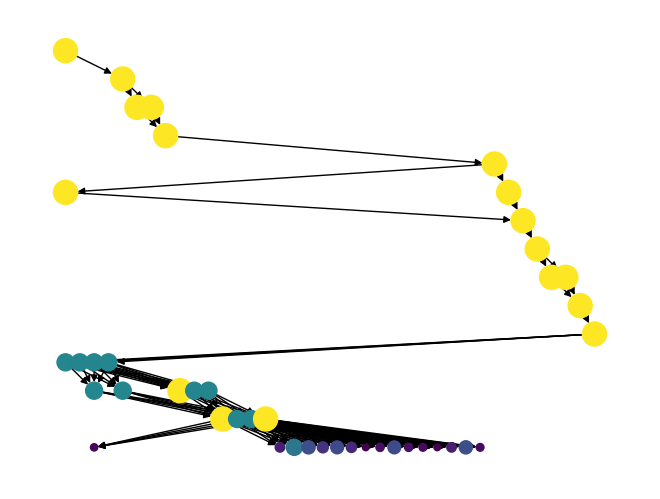

In [259]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame
logic_clause = logic_clause[sort_index]
data = logic_clause.transpose()

df = pd.DataFrame(data)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on DataFrame
for level in range(len(df.index) - 1):
    for col in df.columns:
        parent = (level, col)
        child_level = level + 1
        for child_col in df.columns:
            child = (child_level, child_col)
            # Add edge with weight as the activity level of the child node
            G.add_edge(parent, child, weight=df.loc[df.index[child_level], child_col])

# Add node attributes for activity level
for level in range(len(df.index)):
    for col in df.columns:
        node = (level, col)
        G.nodes[node]['activity'] = df.loc[df.index[level], col]

# Identify nodes with activity level of 0
nodes_to_remove = [node for node in G.nodes if G.nodes[node]['activity'] == 0]

# Remove these nodes and their associated edges
G.remove_nodes_from(nodes_to_remove)

# Position the nodes in a hierarchical layout
pos = {}
for level in range(len(df.index)):
    for i, col in enumerate(df.columns):
        pos[(level, col)] = (i, -level)

# Draw the nodes with sizes proportional to activity levels
node_sizes = [G.nodes[node]['activity'] * 300 for node in G.nodes]
nx.draw(G, pos, with_labels=False, 
        node_size=node_sizes, 
        node_color=node_sizes, 
        font_weight='bold')

# Draw the edge labels with weights
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Set grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()